<a href="https://colab.research.google.com/github/abdulmajee/news_data_augmetation/blob/main/Machine_learning_multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/metin_dosyasi_dataframe.csv")
df.head()

,text,Careers,Personal_Finance,Religion_&_Spirituality,Travel,Science,Food_&_Drink,Events_and_Attractions,Real_Estate,Family_and_Relationships,...,Automotive,Medical_Health,Books_and_Literature,Style_&_Fashion,Fine_Art,Technology_&_Computing,Music_and_Audio,Business_and_Finance,Video_Gaming,Education
0,çocuk sağlığı hastalıkları hastaneler hastanel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i̇htiyaç kredisi enpara com i̇çeriğe git alt b...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,kariyer gelişiminde ay işığı sorunu dünya gaze...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,kocaeli istihdam fuarı kariyer günleri başladı...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,müzik nedir nasıl bir sanattır müzik tarihçesi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Number of comments in each category

In [8]:
df_labels = df.drop(['text'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Careers,110
1,Personal_Finance,122
2,Religion_&_Spirituality,106
3,Travel,109
4,Science,105
5,Food_&_Drink,126
6,Events_and_Attractions,106
7,Real_Estate,108
8,Family_and_Relationships,169
9,Sports,110


Display of the statistics

Text(0.5, 0, 'category')

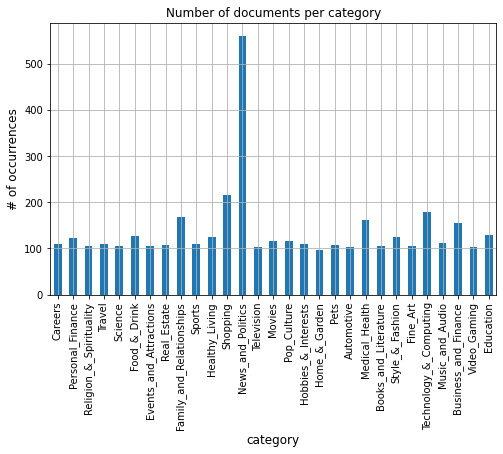

In [9]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of documents per category")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

How many of the Documents have multi-labels ?

In [10]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

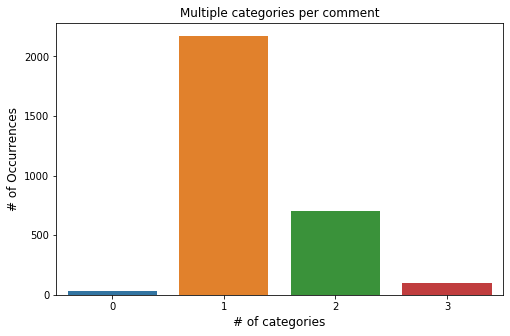

In [11]:
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

All our documents are labeled, and at least more than 500 documents are multi-labeled.
Maximum number of multi-labels we have per document is 3. That is a single document has at most 3 different categories and no document is unlabeled.

The distribution of the number of words in each document provided.
bold text

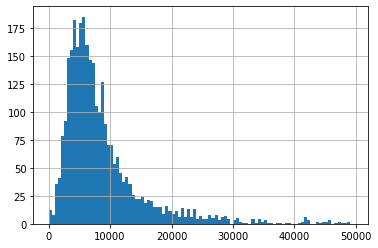

In [16]:
lens = df.text.str.len()
lens.hist(bins = np.arange(0,50000,500))

Most of the comment text length are within 5000 characters, with some outliers up to 50,000 characters long.

# Split the data to train and test sets:

In [17]:
categories  #['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

['Careers',
 'Personal_Finance',
 'Religion_&_Spirituality',
 'Travel',
 'Science',
 'Food_&_Drink',
 'Events_and_Attractions',
 'Real_Estate',
 'Family_and_Relationships',
 'Sports',
 'Healthy_Living',
 'Shopping',
 'News_and_Politics',
 'Television',
 'Movies',
 'Pop_Culture',
 'Hobbies_&_Interests',
 'Home_&_Garden',
 'Pets',
 'Automotive',
 'Medical_Health',
 'Books_and_Literature',
 'Style_&_Fashion',
 'Fine_Art',
 'Technology_&_Computing',
 'Music_and_Audio',
 'Business_and_Finance',
 'Video_Gaming',
 'Education']

In [18]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)

In [19]:
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(2106,)
(903,)


# **Classifiers Training**

## OneVsRest multi-label strategy

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

## Naive Bayes

OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrap Naive Bayes in the OneVsRestClassifier.

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('turkish'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Careers
Test accuracy is 0.964562569213732
... Processing Personal_Finance
Test accuracy is 0.9656699889258029
... Processing Religion_&_Spirituality
Test accuracy is 0.9534883720930233
... Processing Travel
Test accuracy is 0.9712070874861573
... Processing Science
Test accuracy is 0.9656699889258029
... Processing Food_&_Drink
Test accuracy is 0.955703211517165
... Processing Events_and_Attractions
Test accuracy is 0.9712070874861573
... Processing Real_Estate
Test accuracy is 0.9601328903654485
... Processing Family_and_Relationships
Test accuracy is 0.9446290143964563
... Processing Sports
Test accuracy is 0.9656699889258029
... Processing Healthy_Living
Test accuracy is 0.9501661129568106
... Processing Shopping
Test accuracy is 0.9446290143964563
... Processing News_and_Politics
Test accuracy is 0.8294573643410853
... Processing Television
Test accuracy is 0.964562569213732
... Processing Movies
Test accuracy is 0.9700996677740864
... Processing Pop_Culture
Test ac

## LinearSVC

In [23]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Careers
Test accuracy is 0.9867109634551495
... Processing Personal_Finance
Test accuracy is 0.991140642303433
... Processing Religion_&_Spirituality
Test accuracy is 0.9811738648947951
... Processing Travel
Test accuracy is 0.9933554817275747
... Processing Science
Test accuracy is 0.9867109634551495
... Processing Food_&_Drink
Test accuracy is 0.982281284606866
... Processing Events_and_Attractions
Test accuracy is 0.9800664451827242
... Processing Real_Estate
Test accuracy is 0.9878183831672204
... Processing Family_and_Relationships
Test accuracy is 0.9678848283499446
... Processing Sports
Test accuracy is 0.9977851605758582
... Processing Healthy_Living
Test accuracy is 0.982281284606866
... Processing Shopping
Test accuracy is 0.9612403100775194
... Processing News_and_Politics
Test accuracy is 0.9125138427464009
... Processing Television
Test accuracy is 0.9933554817275747
... Processing Movies
Test accuracy is 0.991140642303433
... Processing Pop_Culture
Test acc

## Logistic Regression

In [24]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Careers
Test accuracy is 0.9689922480620154
... Processing Personal_Finance
Test accuracy is 0.9800664451827242
... Processing Religion_&_Spirituality
Test accuracy is 0.9534883720930233
... Processing Travel
Test accuracy is 0.9867109634551495
... Processing Science
Test accuracy is 0.9667774086378738
... Processing Food_&_Drink
Test accuracy is 0.9634551495016611
... Processing Events_and_Attractions
Test accuracy is 0.9712070874861573
... Processing Real_Estate
Test accuracy is 0.9723145071982281
... Processing Family_and_Relationships
Test accuracy is 0.9490586932447398
... Processing Sports
Test accuracy is 0.9800664451827242
... Processing Healthy_Living
Test accuracy is 0.9501661129568106
... Processing Shopping
Test accuracy is 0.9568106312292359
... Processing News_and_Politics
Test accuracy is 0.9047619047619048
... Processing Television
Test accuracy is 0.9756367663344407
... Processing Movies
Test accuracy is 0.973421926910299
... Processing Pop_Culture
Test 